## Предсказание ухода игроков в онлайн-игре на платформе iOs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline  

Загрузим данные:

In [2]:
data = pd.read_csv('practice_sessions_ios.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

In [3]:
data.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate
0,00e954a1b3,12.0,29,1486997200,1486997229,2017-02-13
1,028498cd03,1.0,445,1485039376,1485039821,2017-01-21
2,12ab1dfa82,8.0,0,1486756815,1486756815,2017-02-10
3,0a0a1ffe3b,5.0,2846,1484976494,1484979340,2017-01-21
4,01c68437aa,7.0,1610,1484329332,1484330942,2017-01-13


# Overview

Перед тем, как приступить к предсказанию, немного посмотрим, что представляют из себя данные:

**Распределение количества сессий по дням:**

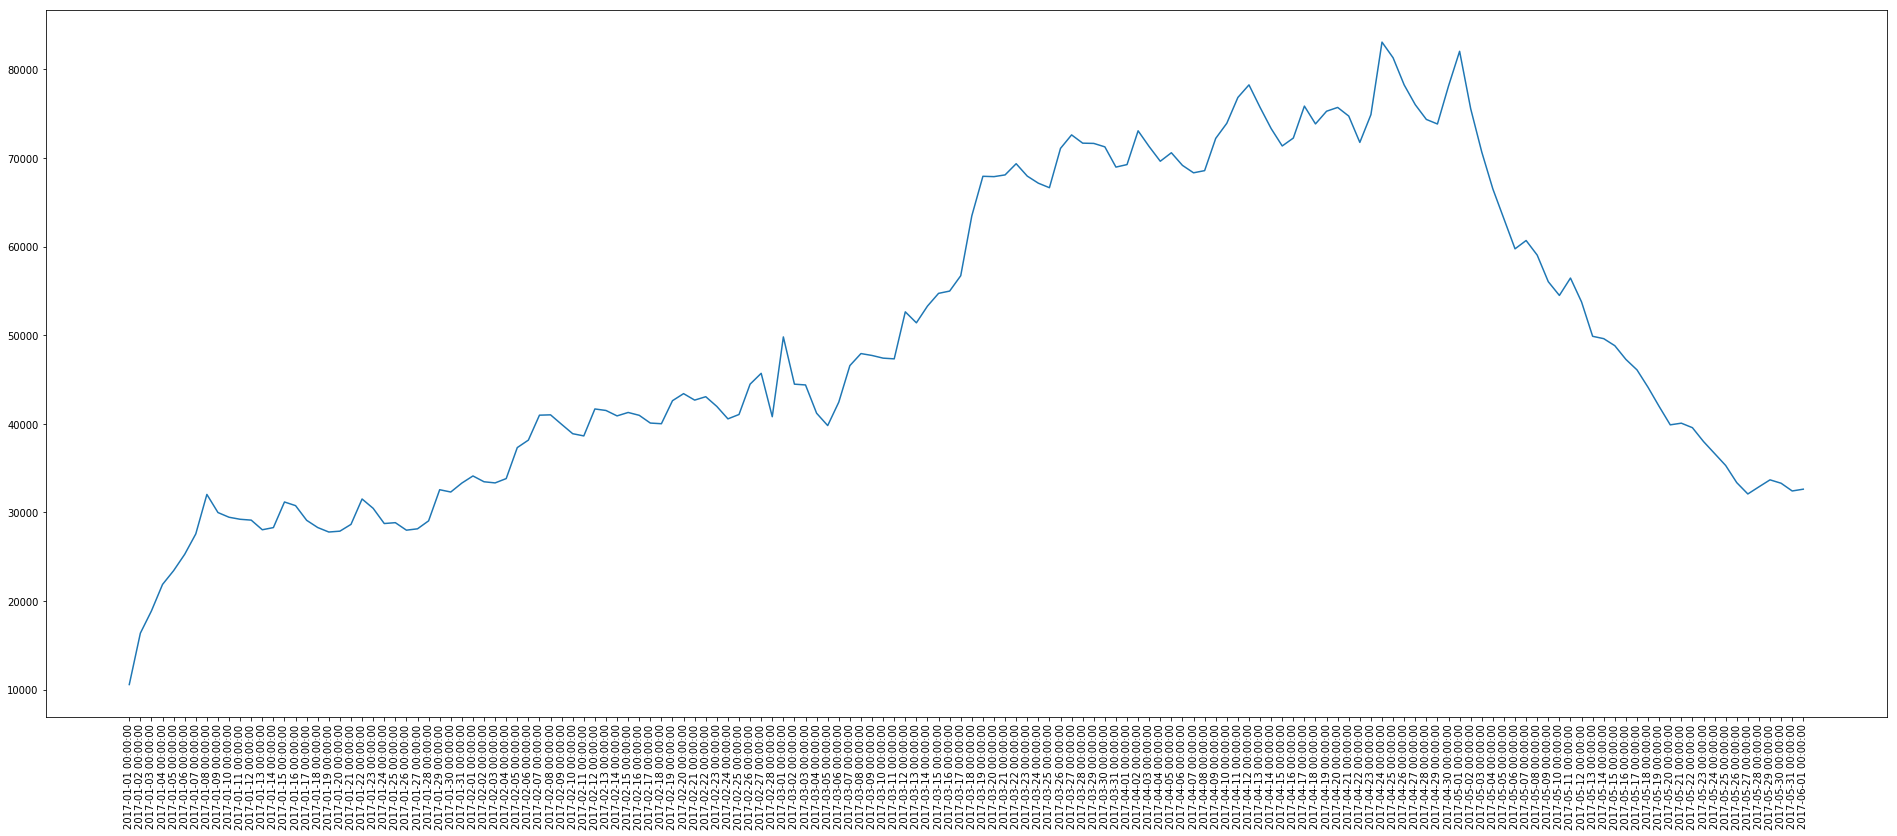

In [4]:
sessions_per_day = data[['actdate', 'id']].groupby('actdate').count().reset_index().rename(columns={'id':'count_sessions'})

fig = plt.figure(figsize=(33, 13))
plt.plot(sessions_per_day[['count_sessions']].values)
plt.xticks(np.arange(sessions_per_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in sessions_per_day['actdate'].values], rotation=90);

Так как до определенного момента наблюдался почти постоянный рост количества сессий, брать топ 10% дней и смотреть на их дни недели неразумно, так что посмотрим на пики (чтоб проверить теорию, что больше всего играют по выходным):

Пики по дням недели:

In [5]:
from scipy.signal import argrelextrema
import calendar

peaks = sessions_per_day['actdate'][argrelextrema(sessions_per_day[['count_sessions']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       10
Wednesday    10
Monday        7
Thursday      2
Name: 0, dtype: int64

**Распределение числа уникальных пользователей в игре по дням:**

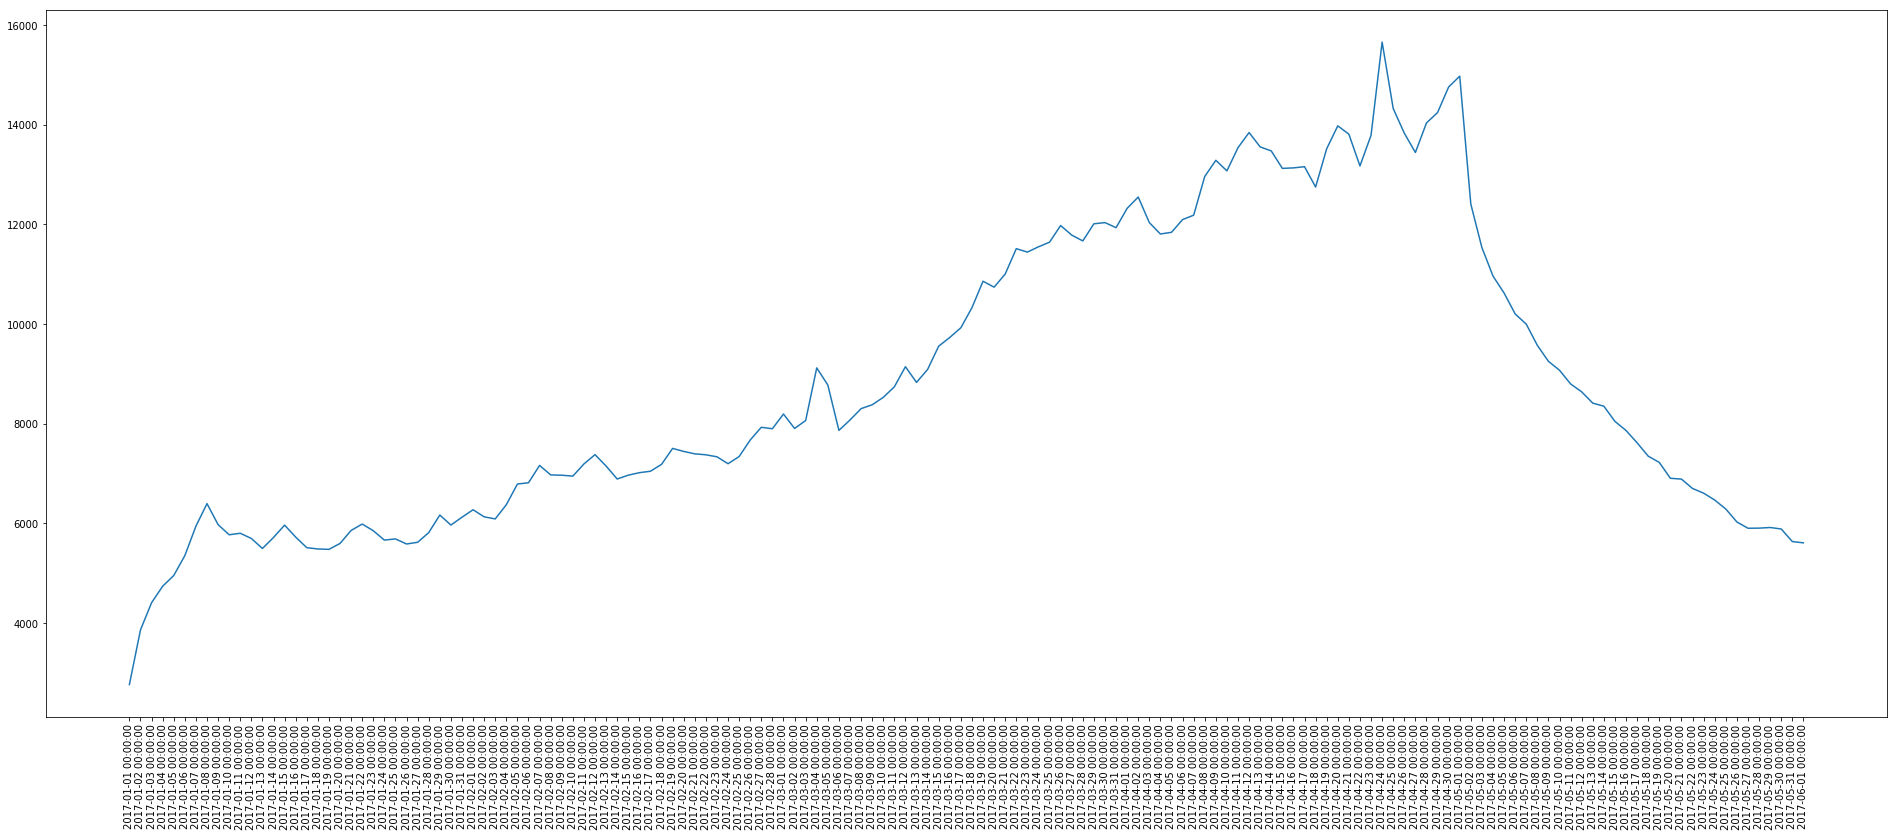

In [6]:
players_per_day = data.groupby(['actdate', 'id']).count().reset_index()[['actdate', 'id']].groupby('actdate').count().reset_index().rename(columns={'id':'count_players'})

fig = plt.figure(figsize=(33, 13))
plt.plot(players_per_day[['count_players']].values)
plt.xticks(np.arange(players_per_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in players_per_day['actdate'].values], rotation=90);

In [7]:
peaks = players_per_day['actdate'][argrelextrema(players_per_day[['count_players']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       11
Wednesday     6
Monday        5
Thursday      2
Tuesday       1
Saturday      1
Name: 0, dtype: int64

**Распределение регистрации новых пользователей по дням:**

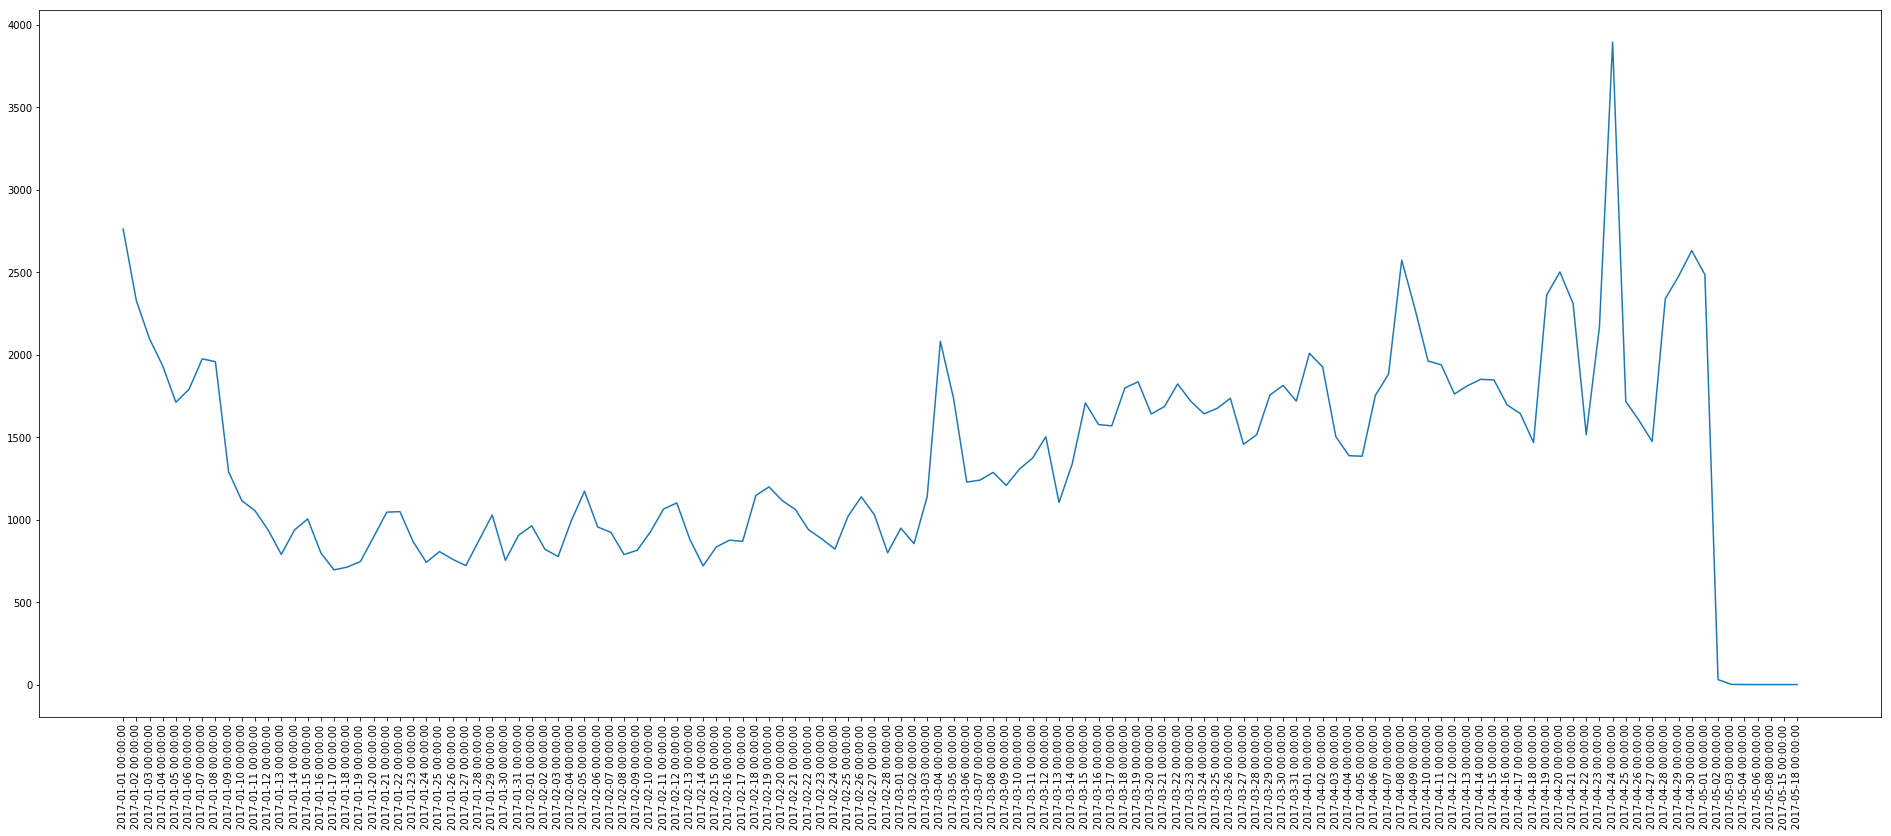

In [8]:
first_appearances = data[['id', 'actdate']].sort_values('actdate').groupby(['id']).first().reset_index()
first_appearances.columns = ['id', 'first_appearance']
growth_by_day = first_appearances.reset_index().groupby('first_appearance').count().reset_index().rename(columns={'id':'count_new_players'})

fig = plt.figure(figsize=(33, 13))
plt.plot(growth_by_day[['count_new_players']].values)
plt.xticks(np.arange(growth_by_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in growth_by_day['first_appearance'].values], rotation=90);

In [9]:
peaks = growth_by_day['first_appearance'][argrelextrema(growth_by_day[['count_new_players']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       11
Wednesday     6
Saturday      4
Thursday      3
Monday        1
Friday        1
Name: 0, dtype: int64

Основываясь на полученные данные о пиках, можно сказать, что больше всего играют в выходные, а так же в середине недели, в среду.

# Prediction

Задача - по данным игроков за первые 30 дней, проведенных ими в игре, предсказать, сколько дней они проведут в следующие 2 недели. Сначала предскажем, останется ли человек вообще (останется = проведет 3 дня или больше), далее, если останется, займемся предсказанием количеством дней.

Подготовим данные. Нужно получить таблицу с одной строкой для каждого игрока и с 30-ю столбцами, в n-м из которых указано число сессий, проведенных в игроком в n-й с момента его регистрации день, потом уже генерировать остальные признаки.

In [10]:
data = data.merge(first_appearances, on='id', how='left')

Последний день, о сессиях которого имеется информация - 1 июня. Так как необходимо, чтобы в обучающей и тестовой выборке были игроки, которые уже провели в игре 44 дня, удалим всех игроков, проведших в игре меньше:

In [11]:
valid_players = data[data['first_appearance'] < '2017-04-14']

Оставим информацию только о сессиях, проведенных менее, чем через 30 дней с момента регистрации:

In [12]:
from datetime import timedelta
valid_players = valid_players[valid_players['actdate'] < valid_players['first_appearance'] + timedelta(days=30)]

Число сессий по дням для каждого из оставшихся игроков:

In [13]:
valid_players = valid_players.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).count()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})

К информации о каждом из дней добавим порядковый номер дня с момента регистрации игрока:

In [14]:
valid_players = valid_players.merge(first_appearances, on='id', how='left')
valid_players['day_num'] = valid_players['actdate'] - valid_players['first_appearance']
valid_players = valid_players.drop('first_appearance', axis=1)

In [15]:
valid_players = pd.get_dummies(valid_players, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players['id']
valid_players = valid_players[valid_players.columns[1:]].mul(valid_players[valid_players.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players['id'] = ids
valid_players = valid_players.groupby('id').agg('sum').reset_index()
valid_players = valid_players.merge(first_appearances, on='id', how='left')

In [16]:
valid_players.columns.values[1:31] = np.array(['day_num_%d' % c for c in range(0,30)])

Получилось то, что нужно:

In [17]:
valid_players.head()

,id,day_num_0,day_num_1,day_num_2,day_num_3,day_num_4,day_num_5,day_num_6,day_num_7,day_num_8,...,day_num_21,day_num_22,day_num_23,day_num_24,day_num_25,day_num_26,day_num_27,day_num_28,day_num_29,first_appearance
0,000192edb1,6,4,8,4,5,3,1,0,0,...,0,0,0,0,0,0,0,0,0,2017-01-31
1,0001a94437,3,3,4,3,2,1,9,1,6,...,0,0,0,0,0,0,0,0,0,2017-03-11
2,00028007b9,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-03-30
3,000303d57f,4,1,0,1,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-01-26
4,00054738b4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-04-08


## Классификация

Найдем для каждого из игроков число дней, проведенных в течение 2-х недели после первых 30-ти дней:

In [18]:
y = data[(data['actdate'] > data['first_appearance'] + timedelta(days=30)) & (data['actdate'] < data['first_appearance'] + timedelta(days=45))]
y = y.groupby(['id', 'actdate']).count().reset_index().groupby('id').count().reset_index()[['id', 'actdate']]
y.columns = ['id', 'y']

(Здесь и далее значение целевой переменной 1 = человек останется в игре, 0 - отвалится)

In [19]:
valid_players = valid_players.merge(y, on='id', how='left')
valid_players['y'] = valid_players['y'].fillna(0)

Необходимо определиться, в каком случае мы будем считать, что человек останется. Посмотрим на распределение дней, которые люди провели в игре в течение прогнозируемого периода, при условии, что этих дней больше нуля:

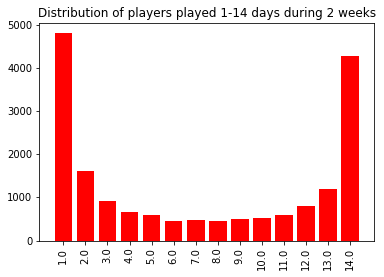

In [20]:
n_days = pd.DataFrame(valid_players[valid_players['y'] > 0]['y'].value_counts()).reset_index().rename(columns={'index':'n_days', 'y':'n_players'}).sort_values('n_days')
plt.bar(range(n_days.shape[0]), n_days['n_players'].values,
       color="r", align="center")
plt.xticks(range(n_days.shape[0]), n_days['n_days'].values, rotation=90);
plt.title('Distribution of players played 1-14 days during 2 weeks');

Видно, что много человек играют один день и пропадают. Число людей, проведших только 2 дня из возможных 14-ти, тоже выше среднего, так что предлагается не считать и этих людей остающимися.

Итак, человек останется, если проведет в игре 3 или больше дней:

In [21]:
valid_players['will_stay'] = (valid_players['y'] > 2).astype(int)
classif_df = valid_players.drop(['y'], axis=1)

На всякий случай визуализируем данные при помощи t-SNE:

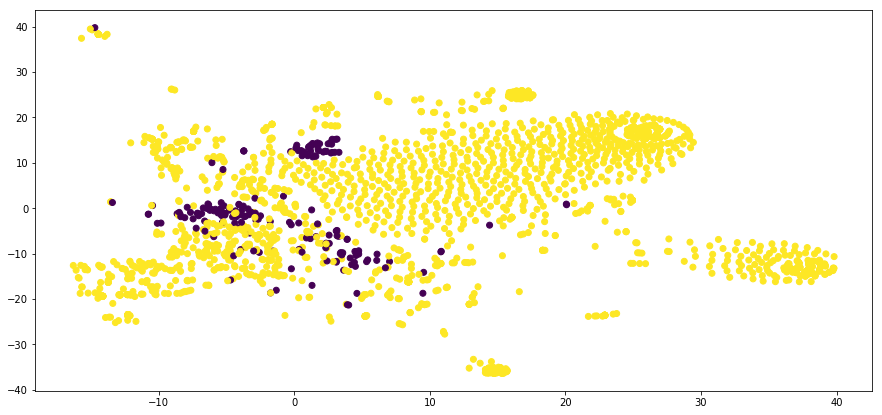

In [23]:
from sklearn.manifold import TSNE
viz = TSNE().fit_transform(valid_players[valid_players.columns[1:-3]].values[:2000])
fig = plt.figure(figsize=(15, 7))
plt.scatter(viz[:,0], viz[:,1], c=(valid_players['y'].values[:2000] < 3).astype(int))

Добавим признаков:

In [25]:
classif_df['sessions_std'] = classif_df[classif_df.columns[1:-2]].std(axis=1)
classif_df['sessions_max'] = classif_df[classif_df.columns[1:-2]].max(axis=1)
classif_df = classif_df.merge(data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
classif_df = classif_df.merge(data.groupby(['id'])[['session_length']].mean().reset_index().rename(columns={'session_length':'session_length_mean'}), on='id', how='left')
classif_df = classif_df.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_std'}).groupby('id')[['time_per_day_std']].std().reset_index(), on='id', how='left')
classif_df = classif_df.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_max'}).groupby('id')[['time_per_day_max']].max().reset_index(), on='id', how='left')
classif_df = classif_df.fillna(0)

Сделаем разделение по времени: в обучающей выборке игроки, начавшие играть раньше, чем игроки из тестовой (дата выбрана исходя из пропорции размер обучеющей:размер тестовой = примерно 4:1):

In [26]:
x_columns = classif_df.columns[1:31].tolist() + classif_df.columns[33:].tolist()
X_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][x_columns].values
y_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][classif_df.columns[32]].values
X_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][classif_df.columns[32]].values

Обучим несколько моделей и сравним результаты. Сначала попробуем модели только на стандартных признаках:

**GradientBoostingClassifier**

Подберем гиперпараметры:

In [309]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50,100,200,500,1000],
    'learning_rate': [0.01, 0.05, 0.1]
}

gr = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'n_estimators': 500, 'learning_rate': 0.01}


In [311]:
param_grid = {
    'max_depth':range(5,16,2),
    'min_samples_split':range(200,1001,200)
}
gr = GridSearchCV(GradientBoostingClassifier(learning_rate=0.01, n_estimators=500), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 800}


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=5,min_samples_split=800)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ["Won't stay", "Will stay"]
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      0.99      0.99     25842
  Will stay       0.88      0.84      0.86      1869

avg / total       0.98      0.98      0.98     27711

Confusion matrix:
 [[25620   222]
 [  296  1573]]


Т.к. гиперпараметры подбирались долго (много деревьев), а результат почти не менялся, я не стал подбирать остальные.

**CatBoostClassifier**

In [292]:
param_grid = {
    'learning_rate': [i/10.0 for i in range(0,5)],
    'l2_leaf_reg': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}

gr = GridSearchCV(CatBoostClassifier(), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'l2_leaf_reg': 100, 'learning_rate': 0.1}


In [52]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(l2_leaf_reg=100, learning_rate=0.1, auto_stop_pval=1e-10, eval_metric='Recall')
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [53]:
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      0.99      0.99     25842
  Will stay       0.89      0.83      0.86      1869

avg / total       0.98      0.98      0.98     27711

Confusion matrix:
 [[25641   201]
 [  311  1558]]


**XGBClassifier**

In [243]:
param_grid_xgcl_1 = {
    'n_estimators':[50,100,200,500,1000]
}
gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_1, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'n_estimators': 100}


In [242]:
param_grid_xgcl_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_1, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 3, 'min_child_weight': 3}


In [251]:
param_grid_xgcl_2 = {
     'gamma':[i/10.0 for i in range(0,5)],
     'learning_rate': [i/10.0 for i in range(1,5)]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3), param_grid_xgcl_2, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'gamma': 0.2, 'learning_rate': 0.1}


In [252]:
param_grid_xgcl_3 = {
     'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1), param_grid_xgcl_3, 
                  scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'reg_alpha': 0.01}


In [253]:
param_grid_xgcl_4 = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1, reg_alpha=0.01), 
                  param_grid_xgcl_4, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'subsample': 0.5, 'colsample_bytree': 0.7}


In [28]:
from xgboost import XGBClassifier
cl = XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1, reg_alpha=0.01, subsample=0.5,
                   colsample_bytree=0.7)
cl.fit(X_train, y_train)
pred = cl.predict(X_test)

In [30]:
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      0.99      0.99     25842
  Will stay       0.88      0.83      0.86      1869

avg / total       0.98      0.98      0.98     27711

Confusion matrix:
 [[25640   202]
 [  317  1552]]


Оценим важность признаков в полученной модели **xgboost**:

Top 10 features:
1. time_per_day_std (0.212934)
2. time_per_day_max (0.157729)
3. day_num_29 (0.077287)
4. session_length_mean (0.064669)
5. session_length_std (0.053628)
6. day_num_28 (0.048896)
7. sessions_std (0.031546)
8. day_num_26 (0.028391)
9. day_num_27 (0.026814)
10. day_num_24 (0.025237)


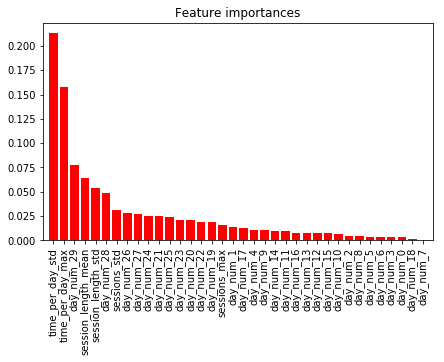

In [32]:
importances = cl.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, x_columns[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(7,4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), np.array(x_columns)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Ожидаемо, наибольшую важность имеют признаки, характеризующие количество сессий в последние дни наблюдаемого периода (особенно в 2 последних), так как если человек до сих пор продолжает играть в 26-27-28-29 дни, вероятность того, что он и впредь продолжит играть, сильно повышается, а так же сгенерированные признаки.

В целом, результат по разным моделям получился примерно одинаковым.

-----------------------------------------------
Попробуем модель **PCA + xgboost**:

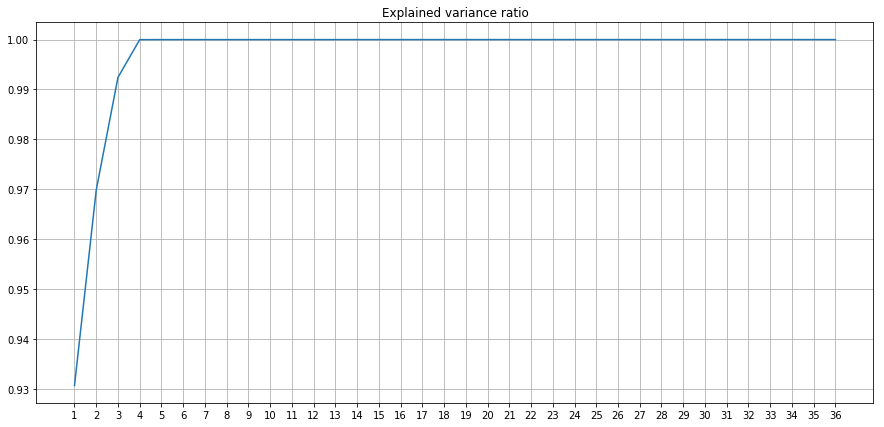

In [33]:
from sklearn.decomposition import PCA
plt.figure(figsize=(15,7))
plt.plot(PCA().fit(X_train).explained_variance_ratio_.cumsum())
plt.title('Explained variance ratio')
plt.xticks(list(range(0,36)), list(range(1,37)));
plt.grid()

Излом при n=4

In [34]:
pca = PCA(n_components=4)
X_train_tr = pca.fit_transform(X_train)
X_test_tr = pca.transform(X_test)

In [39]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_tr, y_train)
pred = model.predict(X_test_tr)

In [40]:
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.98      0.98      0.98     25842
  Will stay       0.76      0.67      0.71      1869

avg / total       0.96      0.96      0.96     27711

Confusion matrix:
 [[25446   396]
 [  610  1259]]


## Регрессия

Для тех, кто останется, предскажем количество дней, которое они проведут в игре в следующие две недели::

In [41]:
regr_data = valid_players[valid_players['will_stay'] == 1].drop(['will_stay'], axis=1)

Добавим признаков:
1. Std количества сессий в день
2. Максимальное число сессий в день
3. Std длины одной сессии
4. Средняя длина одной сессии
5. Std времени, проводимого в игре за день
6. Максимальное время, проведенное в игре за день

In [42]:
regr_data['sessions_std'] = regr_data[regr_data.columns[:-1]].std(axis=1)
regr_data['sessions_max'] = regr_data[regr_data.columns[:-1]].max(axis=1)
regr_data = regr_data.merge(data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
regr_data = regr_data.merge(data.groupby(['id'])[['session_length']].mean().reset_index().rename(columns={'session_length':'session_length_mean'}), on='id', how='left')
regr_data = regr_data.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_std'}).groupby('id')[['time_per_day_std']].std().reset_index(), on='id', how='left')
regr_data = regr_data.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_max'}).groupby('id')[['time_per_day_max']].max().reset_index(), on='id', how='left')

In [43]:
x_columns = regr_data.columns.tolist()[1:-8] + regr_data.columns.tolist()[-6:]
X_train = regr_data[regr_data['first_appearance'] < '2017-03-30'][x_columns].values
y_train = regr_data[regr_data['first_appearance'] < '2017-03-30'][regr_data.columns[-7]].values
X_test = regr_data[regr_data['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = regr_data[regr_data['first_appearance'] >= '2017-03-30'][regr_data.columns[-7]].values

Попробуем **CatBoost**:

In [259]:
param_grid = {
    'learning_rate': [i/10.0 for i in range(0,5)],
    'l2_leaf_reg': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}

gr = GridSearchCV(CatBoostRegressor(), param_grid, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'l2_leaf_reg': 0.01, 'learning_rate': 0.1}


In [209]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
model = CatBoostRegressor(l2_leaf_reg=0.01, learning_rate=0.1, auto_stop_pval=1e-10, eval_metric='MAE')
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                       np.sqrt(mean_squared_error(y_test, pred))))

MAE: 1.7986
r2: 0.6024
RMSE: 2.5022


Попробуем **xgboost**:

In [53]:
from xgboost import XGBRegressor

In [62]:
param_grid_xgreg_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':np.arange(100,1000,200)
}

gr = GridSearchCV(XGBRegressor(), param_grid_xgreg_1, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'min_child_weight': 3, 'n_estimators': 100, 'max_depth': 5}


In [63]:
param_grid_xgreg_2 = {
    'gamma':[i/10.0 for i in range(0,5)],
    'learning_rate': [i/10.0 for i in range(0,5)]
}
gr = GridSearchCV(XGBRegressor(max_depth=7, min_child_weight=1), param_grid_xgreg_2, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'gamma': 0.1, 'learning_rate': 0.1}


In [72]:
param_grid_xgreg_3 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBRegressor(max_depth=7, min_child_weight=1, gamma=0.3, learning_rate=0.1), param_grid_xgreg_3, 
                  scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'reg_alpha': 1e-5}


In [65]:
param_grid_xgreg_4 = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]
}
gr = GridSearchCV(XGBRegressor(max_depth=7, min_child_weight=1, gamma=0.3, learning_rate=0.1, reg_alpha=10),
                  param_grid_xgreg_4, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'colsample_bytree': 1.0, 'subsample': 1.0}


In [44]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1, reg_alpha=1e-05, subsample=1,
                     colsample_bytree=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                              np.sqrt(mean_squared_error(y_test, pred))))

MAE: 1.7482
r2: 0.6099
RMSE: 2.4784


Оценим важность признаков: (f0-f29 - дни 0-29)

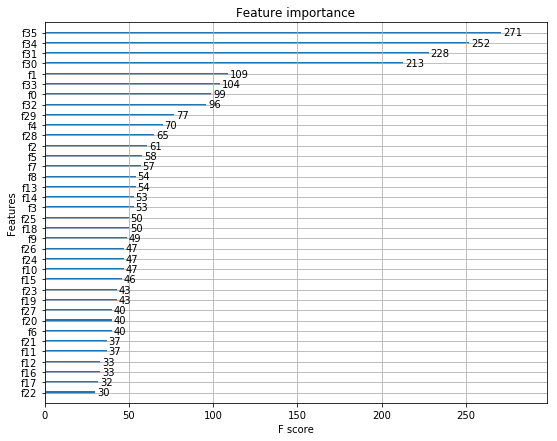

In [48]:
from xgboost import plot_importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(9, 7)

Видно, что наиболее часто разбиение в деревьях происходило как раз по сгенерированным признакам, т.е. они оказались полезными, а наиболее важное значение имеют характеристики, связанные со временем, проводимым в игре за день день.

In [49]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

for train_index, test_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index])
    pred = model.predict(X_train[test_index])
    print(mean_absolute_error(pred, y_train[test_index]))

1.55225048801
1.55914224261
1.57254535902


По более старым данным качество лучше, т.е. разбивать на обучение и тест по времени важно

# Результат

Здесь представлены не все методы, которые я испробовал, а в большинстве только те, что дали наилуший результат. Например, PCA в регрессии не привел к хорошим результатам, так что я не стал его оставлять. Также я добавлял другие признаки, но какие-то из них не привнесли ничего нового (такие, как *sessions_min*, *sessions_mean*, *session_length_min* и т.д. оказывались последними в *feature\_importances\_*). 

# Тест моделей на данных с android

Проверим качество моделей на аналогичных данных с платформы android:

In [2]:
data = pd.read_csv('practice_sessions_and.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

In [4]:
total_ids = np.unique(data['id'].values)
ids = np.random.choice(np.unique(data['id'].values), 1500000, replace=True)

In [5]:
data = data[data['id'].isin(ids)]

In [6]:
first_appearances = data[['id', 'actdate']].sort_values('actdate').groupby(['id']).first().reset_index()
first_appearances.columns = ['id', 'first_appearance']
data = data.merge(first_appearances, on='id', how='left')
valid_players = data[data['first_appearance'] < '2017-04-14']

In [7]:
from datetime import timedelta
valid_players = valid_players[valid_players['actdate'] < valid_players['first_appearance'] + timedelta(days=30)]
valid_players = valid_players.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).count()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})
valid_players = valid_players.merge(first_appearances, on='id', how='left')

In [8]:
valid_players['day_num'] = valid_players['actdate'] - valid_players['first_appearance']
valid_players = valid_players.drop('first_appearance', axis=1)
valid_players = pd.get_dummies(valid_players, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players['id']
valid_players = valid_players[valid_players.columns[1:]].mul(valid_players[valid_players.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players['id'] = ids
valid_players = valid_players.groupby('id').agg('sum').reset_index()
valid_players = valid_players.merge(first_appearances, on='id', how='left')
valid_players.columns.values[1:31] = np.array(['day_num_%d' % c for c in range(0,30)])

In [9]:
y = data[(data['actdate'] > data['first_appearance'] + timedelta(days=30)) & (data['actdate'] < data['first_appearance'] + timedelta(days=45))]
y = y.groupby(['id', 'actdate']).count().reset_index().groupby('id').count().reset_index()[['id', 'actdate']]
y.columns = ['id', 'y']

In [10]:
valid_players = valid_players.merge(y, on='id', how='left')
valid_players['y'] = valid_players['y'].fillna(0)

In [11]:
valid_players['will_stay'] = (valid_players['y'] > 2).astype(int)
classif_df = valid_players.drop(['y'], axis=1)

In [12]:
(classif_df['first_appearance'] < '2017-03-12').sum()/classif_df.shape[0]

0.79973359544897493

In [13]:
classif_df['sessions_std'] = classif_df[classif_df.columns[1:-2]].std(axis=1)
classif_df['sessions_max'] = classif_df[classif_df.columns[1:-2]].max(axis=1)
classif_df = classif_df.merge(data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
classif_df = classif_df.merge(data.groupby(['id'])[['session_length']].mean().reset_index().rename(columns={'session_length':'session_length_mean'}), on='id', how='left')
classif_df = classif_df.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_std'}).groupby('id')[['time_per_day_std']].std().reset_index(), on='id', how='left')
classif_df = classif_df.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_max'}).groupby('id')[['time_per_day_max']].max().reset_index(), on='id', how='left')
classif_df = classif_df.fillna(0)

In [21]:
x_columns = classif_df.columns[1:31].tolist() + classif_df.columns[33:].tolist()
X_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][x_columns].values
y_train = classif_df[classif_df['first_appearance'] < '2017-03-30'][classif_df.columns[32]].values
X_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = classif_df[classif_df['first_appearance'] >= '2017-03-30'][classif_df.columns[32]].values

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=5,min_samples_split=800)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [24]:
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      1.00      1.00     75471
  Will stay       0.86      0.78      0.82      2121

avg / total       0.99      0.99      0.99     77592

Confusion matrix:
 [[75203   268]
 [  472  1649]]


In [15]:
regr_data = valid_players[valid_players['will_stay'] == 1].drop(['will_stay'], axis=1)

In [16]:
regr_data['sessions_std'] = regr_data[regr_data.columns[:-1]].std(axis=1)
regr_data['sessions_max'] = regr_data[regr_data.columns[:-1]].max(axis=1)
regr_data = regr_data.merge(data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
regr_data = regr_data.merge(data.groupby(['id'])[['session_length']].mean().reset_index().rename(columns={'session_length':'session_length_mean'}), on='id', how='left')
regr_data = regr_data.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_std'}).groupby('id')[['time_per_day_std']].std().reset_index(), on='id', how='left')
regr_data = regr_data.merge(data.groupby(['id', 'actdate'])[['session_length']].sum().reset_index().rename(columns={'session_length':'time_per_day_max'}).groupby('id')[['time_per_day_max']].max().reset_index(), on='id', how='left')

In [17]:
x_columns = regr_data.columns.tolist()[1:-8] + regr_data.columns.tolist()[-6:]
X_train = regr_data[regr_data['first_appearance'] < '2017-03-12'][x_columns].values
y_train = regr_data[regr_data['first_appearance'] < '2017-03-12'][regr_data.columns[-7]].values
X_test = regr_data[regr_data['first_appearance'] >= '2017-03-12'][x_columns].values
y_test = regr_data[regr_data['first_appearance'] >= '2017-03-12'][regr_data.columns[-7]].values

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1, reg_alpha=1e-05, subsample=1,
                     colsample_bytree=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                              np.sqrt(mean_squared_error(y_test, pred))))

MAE: 1.8412
r2: 0.6194
RMSE: 2.5522
